# Paris Data Analysis - Alen Rostomyan

## Study of the Dataset - Paris

### Libraries

In [1]:
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

### Data Reading

In [2]:
paris_data = pd.read_csv('Paris.csv')

### Data Cleaning

In [3]:
# Only use wind/time-related features from dataset
useful_columns = ['wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'wind_direction_100m', 'period', 'period_end']

year = 2015
month = 1

# paris_data = paris_data.drop(columns=drop_columns) 
paris_data = paris_data[useful_columns]

index = paris_data[(paris_data.period_end == f"{year}-01-01T00:00:00Z")].iloc[0].name

# Filters data to create subset for data from chosen year
paris_data_subset = paris_data.loc[:index-1]

paris_data_subset.tail()



,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,period,period_end
17514,0.9,0.8,279,309,PT30M,2014-12-31T21:30:00Z
17515,0.7,0.5,256,272,PT30M,2014-12-31T22:00:00Z
17516,0.6,0.5,241,246,PT30M,2014-12-31T22:30:00Z
17517,0.5,0.6,246,241,PT30M,2014-12-31T23:00:00Z
17518,0.6,0.7,241,234,PT30M,2014-12-31T23:30:00Z


### Plotting wind features as a function of time

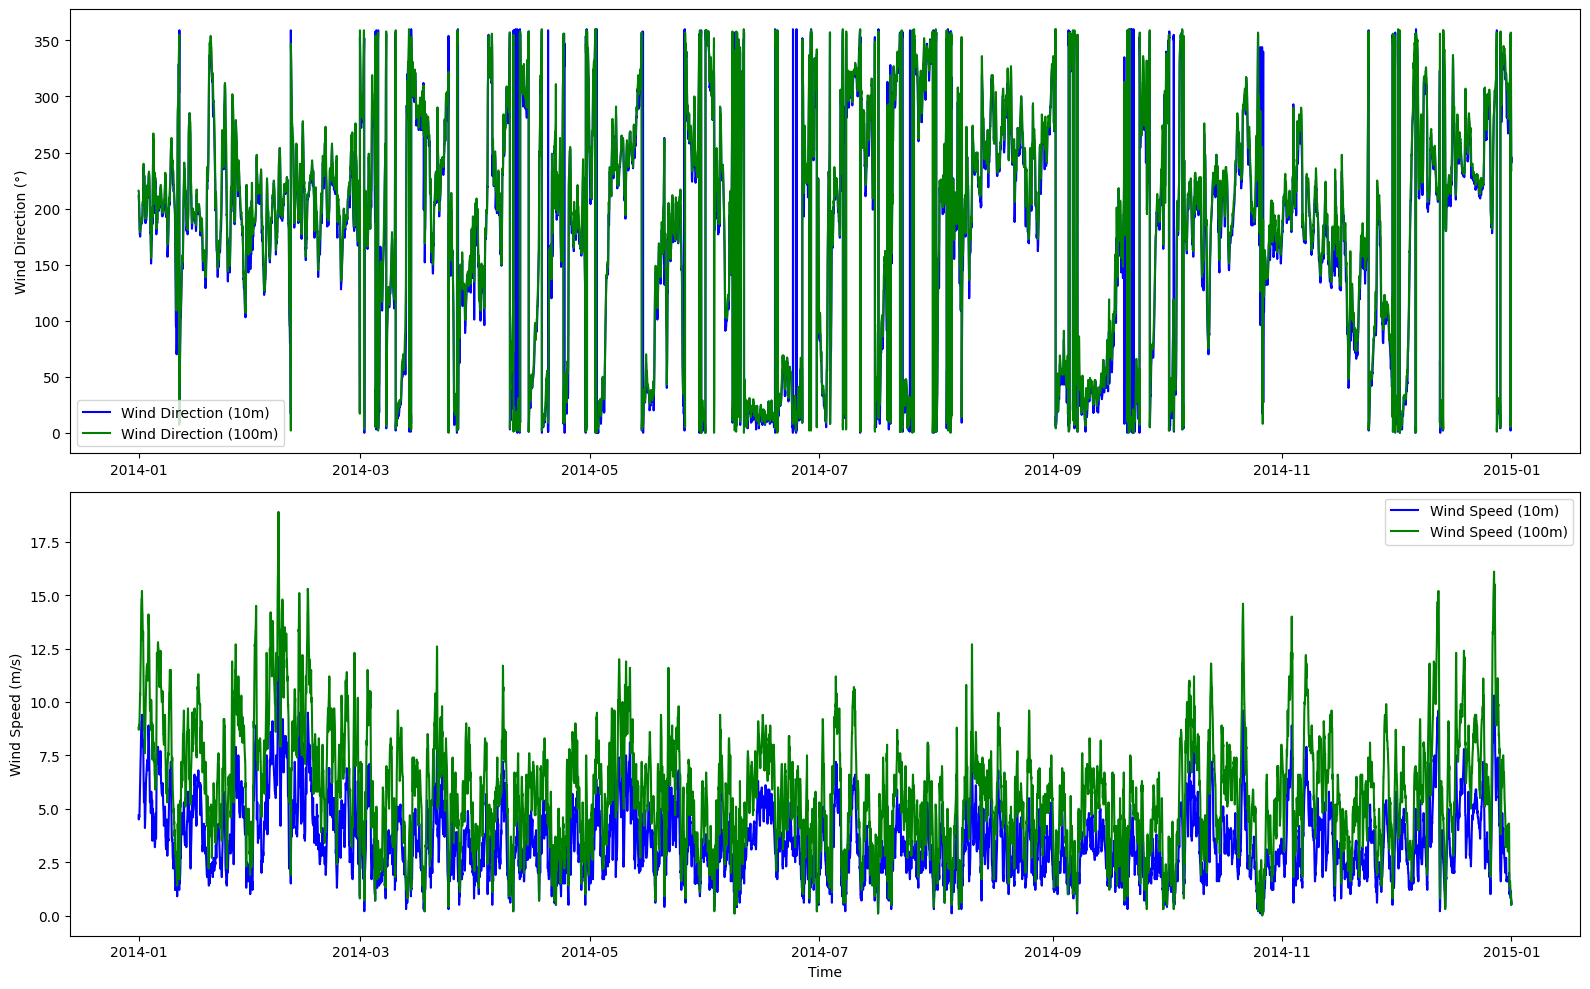

In [4]:
# Prevent SettingWithCopyWarning
plotting_paris_data_subset = paris_data_subset.copy() 

# Convert 'period_end' to datetime and set it as the index
plotting_paris_data_subset['period_end'] = pd.to_datetime(paris_data_subset['period_end'])
plotting_paris_data_subset.set_index('period_end', inplace=True)

# Plot the wind features as a function of time
plt.figure(figsize=(16, 10))

# Wind direction (100m & 10m)
plt.subplot(2, 1, 1)
plt.plot(plotting_paris_data_subset.index, plotting_paris_data_subset['wind_direction_10m'], label='Wind Direction (10m)', color='blue')
plt.plot(plotting_paris_data_subset.index, plotting_paris_data_subset['wind_direction_100m'], label='Wind Direction (100m)', color='green')
plt.ylabel('Wind Direction (°)')
plt.legend()

# Wind speed (100m & 10m)
plt.subplot(2, 1, 2)
plt.plot(plotting_paris_data_subset.index, plotting_paris_data_subset['wind_speed_10m'], label='Wind Speed (10m)', color='blue')
plt.plot(plotting_paris_data_subset.index, plotting_paris_data_subset['wind_speed_100m'], label='Wind Speed (100m)', color='green')
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.legend()

plt.tight_layout()
plt.show()


### Calculating the number of hours during which the wind was not blowing

In [5]:
# Filter data to where both wind speeds are zero
zero_wind_data = paris_data_subset[(paris_data_subset['wind_speed_100m'] == 0) & (paris_data_subset['wind_speed_10m'] == 0)]

# Count number of 30 minute periods with zero wind
zero_wind_periods = zero_wind_data.shape[0]

# Convert to hours
zero_wind_hours = zero_wind_periods * 0.5

print(f"Time without wind: {zero_wind_hours} hours")

Time without wind: 0.0 hours


### Plotting monthly average wind features as a function of number of months

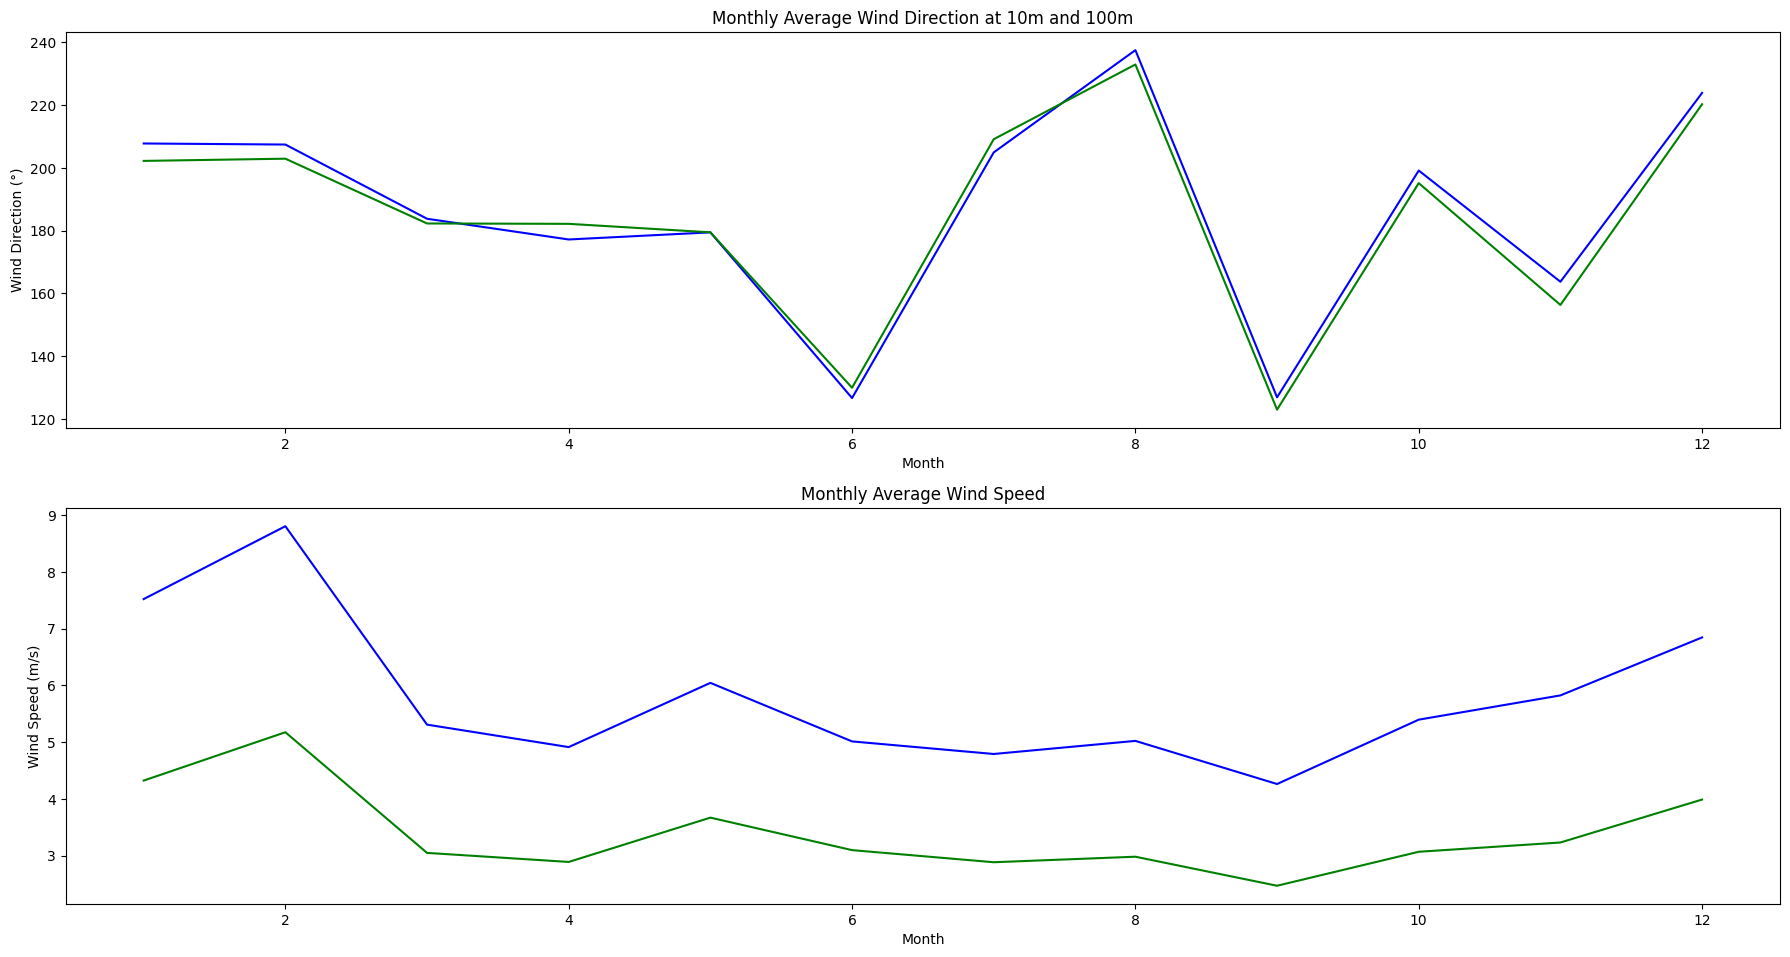

In [6]:
# Prevent SettingWithCopyWarning
plotting_avg_subset = paris_data_subset.copy()

# Convert 'period_end' to datetime and extract the month
plotting_avg_subset['period_end'] = pd.to_datetime(plotting_avg_subset['period_end'])
plotting_avg_subset['month'] = plotting_avg_subset['period_end'].dt.month

monthly_averages = plotting_avg_subset.drop(columns=['period', 'period_end']).groupby('month').mean()

# Plotting the data
plt.figure(figsize=(18, 14))

plt.subplot(3, 1, 1)
plt.plot(monthly_averages.index, monthly_averages['wind_direction_100m'], label='Monthly Average Wind Direction at 100m', color='blue')
plt.plot(monthly_averages.index, monthly_averages['wind_direction_10m'], label='Monthly Average Wind Direction at 10m', color='green')
plt.title('Monthly Average Wind Direction at 10m and 100m')
plt.xlabel('Month')
plt.ylabel('Wind Direction (°)')

plt.subplot(3, 1, 2)
plt.plot(monthly_averages.index, monthly_averages['wind_speed_100m'], label='Monthly Average Wind Speed at 100m', color='blue')
plt.plot(monthly_averages.index, monthly_averages['wind_speed_10m'], label='Monthly Average Wind Speed at 10m', color='green')
plt.title('Monthly Average Wind Speed')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')

plt.tight_layout()
plt.show()

### Plotting wind speed distributions at 10m & 100m above ground

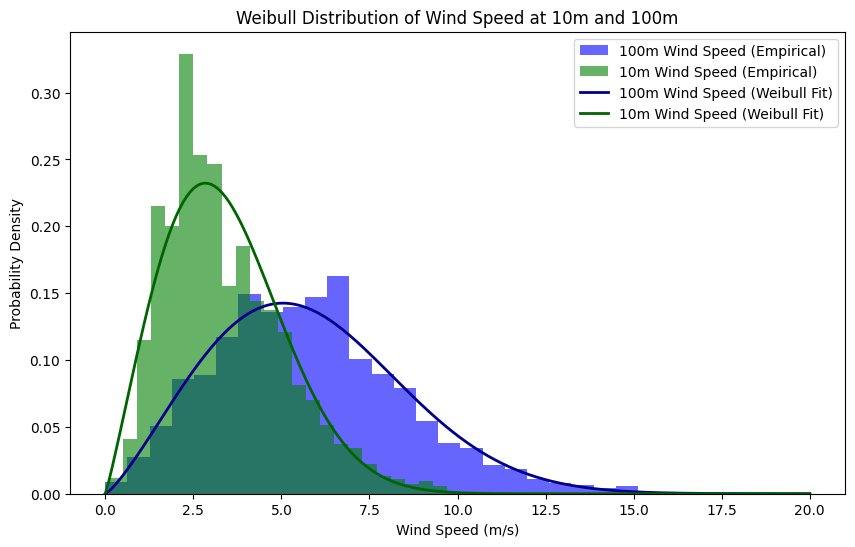

In [7]:
# Prevent SettingWithCopyWarning
wind_speed_subset = paris_data_subset[['wind_speed_10m', 'wind_speed_100m']].copy()

# Display the tail of the subset to verify
wind_speed_subset.tail()

# Define a function for fitting the Weibull distribution to the dataset
def fit_weibull_dist(data):
    shape, loc, scale = weibull_min.fit(data, floc=0)
    return shape, scale

# Fit the Weibull distribution to wind speed at 100m and 10m
shape_100m, scale_100m = fit_weibull_dist(paris_data_subset['wind_speed_100m'])
shape_10m, scale_10m = fit_weibull_dist(paris_data_subset['wind_speed_10m'])

# Generate a range of wind speed for plotting
v_range = np.linspace(0, 20, num=200)

# Compute the Weibull PDF using the fitted parametres
weibull_100m = weibull_min.pdf(v_range, shape_100m, loc=0, scale=scale_100m)
weibull_10m = weibull_min.pdf(v_range, shape_10m, loc=0, scale=scale_10m)

# Plot the empirical distribution and the Weibull PDF
plt.figure(figsize=(10, 6))

# Plot histograms of the actual data
plt.hist(paris_data_subset['wind_speed_100m'], bins=30, density=True, alpha=0.6, color='blue', label='100m Wind Speed (Empirical)')
plt.hist(paris_data_subset['wind_speed_10m'], bins=30, density=True, alpha=0.6, color='green', label='10m Wind Speed (Empirical)')

# Plot the fitted Weibull distributions
plt.plot(v_range, weibull_100m, lw=2, color='darkblue', label='100m Wind Speed (Weibull Fit)')
plt.plot(v_range, weibull_10m, lw=2, color='darkgreen', label='10m Wind Speed (Weibull Fit)')

# Add labels, title, and legend
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability Density')
plt.title('Weibull Distribution of Wind Speed at 10m and 100m')
plt.legend()

# Show the plot
plt.show()


### Finding parametres of best fitting weibull distribution

In [8]:
# Calculate parametres of the Weibull distribution for wind speed at 100m and 10m
params_10m = weibull_min.fit(paris_data_subset['wind_speed_10m'][paris_data_subset['wind_speed_10m'] > 0])
params_100m = weibull_min.fit(paris_data_subset['wind_speed_100m'][paris_data_subset['wind_speed_100m'] > 0])

print(f"Parametres for 10m wind speed weibull distribution{params_10m}")
print(f"Parametres for 100m wind speed weibull distribution{params_100m}")

Parametres for 10m wind speed weibull distribution(1.70825077207765, 0.6594596315771257, 3.0918601958525986)
Parametres for 100m wind speed weibull distribution(2.2535023936919867, 0.000575376417806743, 6.541331890486443)


##### What is the effect of the wind direction,and how should you take that into account when installing your wind turbine?

The effect of wind direction on the installation of wind turbines is significant and should be carefully considered.

1. **Wind Turbine Efficiency**: Wind turbines are designed to extract energy from the wind. The efficiency of a wind turbine is highly dependent on the direction of the wind. Turbines are most efficient when the wind direction aligns with the orientation of the turbine blades. When the wind direction deviates from this optimal alignment, the efficiency of the turbine decreases.

2. **Site Selection**: When selecting a site for installing wind turbines, wind direction patterns should be carefully analyzed. Wind roses, which depict the frequency and direction of wind at a particular location, can provide valuable insights into wind patterns over time. Installing turbines in areas with consistent prevailing wind directions can enhance overall energy production and turbine efficiency.

## Comparitive study of the wind turbine models

##### Alstom ECO122

height: 89m

cut in: 2ms-1

cut off: 26ms-1



##### Enercon E-33

height: 47m

cut in: 2ms-1

cut off: 26ms-1


##### Aventa AV-7

height: 18m

cut in: 1ms-1

cut off: 15ms-1

In [9]:
# Calculate the height of the mast for each turbine model
heights = {
    'Alstom ECO122': 89,
    'Enercon E-33': 47,
    'Aventa AV-7': 18
}

# Create a copy of the subset DataFrame to avoid the SettingWithCopyWarning
paris_data_subset_heights = paris_data_subset.copy()

# Calculate the wind speed at the hub height for each turbine model
for model, height in heights.items():
    # Calculate wind speed at hub height using the wind log profile formula
    paris_data_subset_heights[model + '_wind_speed_hub_height'] = paris_data_subset_heights['wind_speed_100m'] * (np.log((height - 6.67) / 0.03) / np.log((100 - 6.67) / 0.03))

# Display the DataFrame with the new features
paris_data_subset_heights.head()

,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,period,period_end,Alstom ECO122_wind_speed_hub_height,Enercon E-33_wind_speed_hub_height,Aventa AV-7_wind_speed_hub_height
0,4.7,8.8,211,216,PT30M,2014-01-01T00:30:00Z,8.662786,7.881949,6.492758
1,4.5,8.7,210,216,PT30M,2014-01-01T01:00:00Z,8.564345,7.792382,6.418977
2,4.5,8.7,209,215,PT30M,2014-01-01T01:30:00Z,8.564345,7.792382,6.418977
3,4.6,8.8,207,213,PT30M,2014-01-01T02:00:00Z,8.662786,7.881949,6.492758
4,4.7,8.8,206,211,PT30M,2014-01-01T02:30:00Z,8.662786,7.881949,6.492758


### Caculating Operating Hours

In [10]:
# Define cut-in and cut-off wind speeds for each turbine model (in m/s)
cut_in_speeds = {
    'Alstom ECO122': 2,
    'Enercon E-33': 2,
    'Aventa AV-7': 1
}

cut_off_speeds = {
    'Alstom ECO122': 26,
    'Enercon E-33': 26,
    'Aventa AV-7': 15
}

# Calculate operating hours for each turbine model
operating_hours = {}
for model in cut_in_speeds.keys():
    # Filter data points where wind speed is between cut-in and cut-off speeds
    operating_hours[model] = len(paris_data_subset_heights[(paris_data_subset_heights[model + '_wind_speed_hub_height'] >= cut_in_speeds[model]) & 
                                                            (paris_data_subset_heights[model + '_wind_speed_hub_height'] <= cut_off_speeds[model])]) / 2

# Print results
for model, hours in operating_hours.items():
    print(f"Operating Hours for {model}: {hours}")


Operating Hours for Alstom ECO122: 8145.5
Operating Hours for Enercon E-33: 8009.0
Operating Hours for Aventa AV-7: 8529.5


### Calculating power in kWh/year

In [11]:
# Define rated power of each turbine model (in kW)
rated_power = {
    'Alstom ECO122': 2.7e6,
    'Enercon E-33': 330e3,
    'Aventa AV-7': 75e3
}

# Define time interval between data points (in hours)
time_interval_hours = 0.25

# Calculate total power production in kWh/year for each turbine model
total_power_production = {}
for model in rated_power.keys():
    # Calculate power production at each data point using the power curve formula
    power_production = ((paris_data_subset_heights[model + '_wind_speed_hub_height'] / 2) ** 3) * 0.5 * rated_power[model] / 1000  # in kW
    
    # Sum up power production over the entire dataset
    total_power_production[model] = (power_production.sum() * operating_hours[model]) * time_interval_hours

# Print results
for model, power in total_power_production.items():
    print(f"Total Power Production (kWh/year) for {model}: {power}")


Total Power Production (kWh/year) for Alstom ECO122: 1922443098094.801
Total Power Production (kWh/year) for Enercon E-33: 174017302926.28232
Total Power Production (kWh/year) for Aventa AV-7: 23543544438.79769


### Calculating capacity factors

In [12]:
# Define number of hours in a year
hours_in_year = 365 * 24

# Calculate capacity factor for each turbine model
capacity_factors = {}
for model, power in total_power_production.items():
    capacity_factors[model] = power / (rated_power[model] * hours_in_year)

# Print results
for model, factor in capacity_factors.items():
    print(f"Capacity Factor for {model}: {factor}")

Capacity Factor for Alstom ECO122: 81.28036098828011
Capacity Factor for Enercon E-33: 60.19693611674357
Capacity Factor for Aventa AV-7: 35.83492304231003


### Plotting capacity factor as a function of month and year

{1: 59.104073382444575, 2: 59.104073382444575, 3: 59.104073382444575, 4: 59.104073382444575, 5: 59.104073382444575, 6: 59.104073382444575, 7: 59.104073382444575, 8: 59.104073382444575, 9: 59.104073382444575, 10: 59.104073382444575, 11: 59.104073382444575, 12: 59.104073382444575}


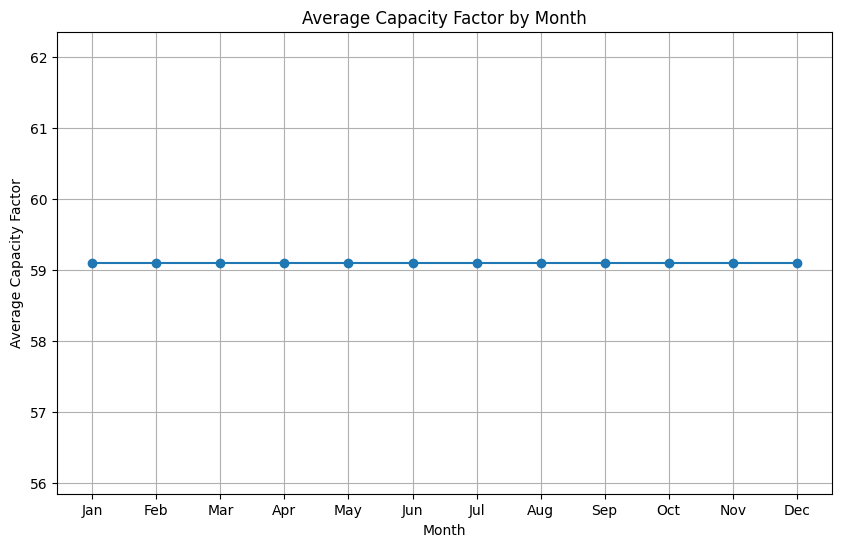

In [13]:
# Group capacity factors by month and calculate average capacity factor for each month
capacity_factors_monthly = {}
for month in range(1, 13):
    capacity_factors_monthly[month] = np.mean([capacity_factors[model] for model in capacity_factors.keys()])

print(capacity_factors_monthly)

# Plot capacity factor as a function of the month
plt.figure(figsize=(10, 6))
plt.plot(capacity_factors_monthly.keys(), capacity_factors_monthly.values(), marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Capacity Factor')
plt.title('Average Capacity Factor by Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


## Analysis

In [14]:
# Calculate total electricity consumption for Paris
population = 2161000  # Population of the Paris
average_consumption_per_person = 5400  # kWh per person per year

total_consumption = population * average_consumption_per_person

# Calculate the number of wind turbines required to match or exceed the town's electricity consumption
num_turbines_required = {}
for model, power in total_power_production.items():
    num_turbines_required[model] = np.ceil(total_consumption / power)

# Define costs (estimate)
costs = { # in USD
    'Alstom ECO122': 2000000,
    'Enercon E-33': 1000000,
    'Aventa AV-7': 300000      
}

total_costs = {
    'Alstom ECO122': costs['Alstom ECO122'] * num_turbines_required['Alstom ECO122'],
    'Enercon E-33': costs['Enercon E-33'] * num_turbines_required['Enercon E-33'],
    'Aventa AV-7': costs['Aventa AV-7'] * num_turbines_required['Aventa AV-7']
}

print(f"Total costs (in USD): {total_costs}")

# Average hourly consumption
average_hourly_consumption = total_consumption / (365 * 24)  # kWh

# Assuming no wind for 5 days (120 hours)
no_wind_period = 120  # hours

# Calculate storage capacity needed to cover no wind period
storage_capacity_needed = average_hourly_consumption * no_wind_period  # kWh

# Print Results
print("Total Electricity Consumption for the Town:", total_consumption, "kWh/year")
print("Number of Wind Turbines Required:")
for model, num_turbines in num_turbines_required.items():
    print(f"{model}: {num_turbines} turbines")
print("Storage Capacity Needed to Cover No Wind Period:", storage_capacity_needed, "kWh")

Total costs (in USD): {'Alstom ECO122': 2000000.0, 'Enercon E-33': 1000000.0, 'Aventa AV-7': 300000.0}
Total Electricity Consumption for the Town: 11669400000 kWh/year
Number of Wind Turbines Required:
Alstom ECO122: 1.0 turbines
Enercon E-33: 1.0 turbines
Aventa AV-7: 1.0 turbines
Storage Capacity Needed to Cover No Wind Period: 159854794.52054793 kWh
